In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
import pandas as pd

df = pd.read_csv('imdb_reviews.csv')

df.head()

,Sentiment,Rating,Review
0,negative,1,Shawshank is nothing more than a fairy tale. I...
1,negative,1,Shawshank Redemption has been elevated in popu...
2,negative,1,This film is nothing but one cliche after anot...
3,negative,1,There are some things in this life we will nev...
4,negative,1,Another one of those overlong morally right-on...


In [82]:
sentiment_counts = df['Sentiment'].value_counts()

sentiment_ratio = sentiment_counts / sentiment_counts.sum()


print(sentiment_ratio)

Sentiment
positive    0.701012
negative    0.171146
neutral     0.127842
Name: count, dtype: float64


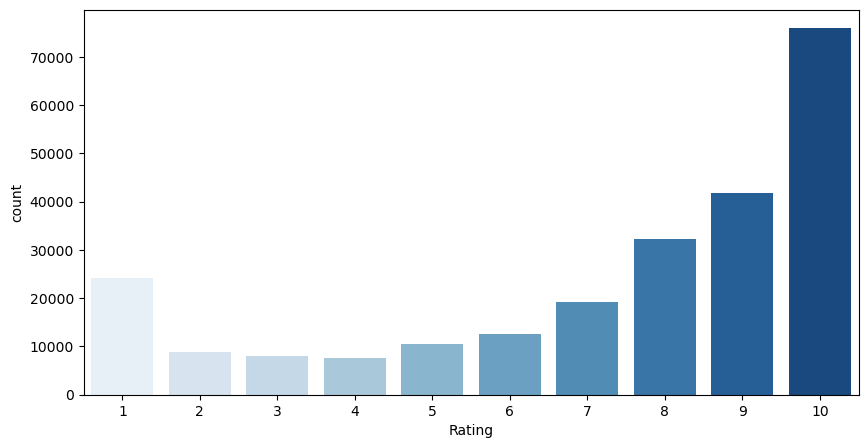

   Rating  count
0      10  75953
1       9  41827
2       8  32303
3       1  24281
4       7  19245
5       6  12581
6       5  10603
7       2   8937
8       3   8122
9       4   7696


In [83]:
# 列印各星等與評論數的直方圖
df['Rating'].value_counts()
tmp = pd.DataFrame(df['Rating'].value_counts())
tmp = tmp.reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Rating', y='count', data=tmp, palette='Blues')
plt.show()
print(tmp)

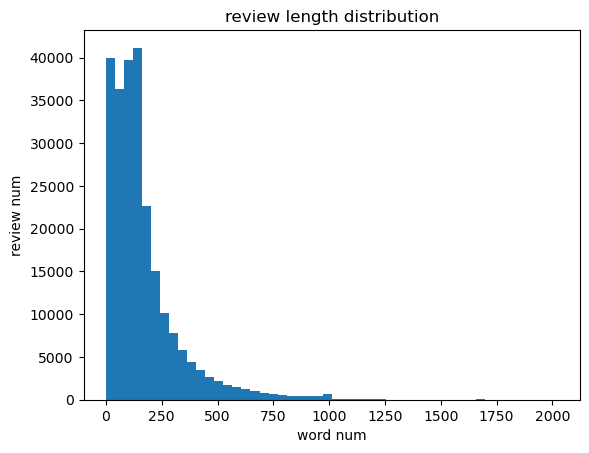

count    241548.000000
mean        168.354998
std         164.872258
min           1.000000
25%          61.000000
50%         126.000000
75%         206.000000
max        2021.000000
Name: word_count, dtype: float64
356.0


In [47]:
# 查看評論長度的分布圖
df["word_count"] = df["Review"].apply(lambda x: len(str(x).split()))


plt.hist(df["word_count"], bins=50)
plt.xlabel("word num")
plt.ylabel("review num")
plt.title("review length distribution")
plt.show()
print(df["word_count"].describe())  
print(df["word_count"].quantile(0.90))  



## LSTM Supervised Learning 1

In [ ]:
%pip install tensorflow

In [76]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [164]:
tokenizer = Tokenizer(num_words=5000, oov_token='{OOV}')

tokenizer.fit_on_texts(df['Review'])
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2} # 標籤對應
df['Sentiment_label'] = df['Sentiment'].map(label_mapping)
sequences = tokenizer.texts_to_sequences(df['Review']) # 將評論轉為sequence

X = pad_sequences(sequences, maxlen=360) # 由於長度360以下的評論占整體90%
y = tf.keras.utils.to_categorical([l for l in df['Sentiment_label']], num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(3, activation="softmax")  
])

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 858s 141ms/step - accuracy: 0.7765 - loss: 0.5758
Epoch 2/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 866s 143ms/step - accuracy: 0.8301 - loss: 0.4340
Epoch 3/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 861s 143ms/step - accuracy: 0.8520 - loss: 0.3820
Epoch 4/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 877s 145ms/step - accuracy: 0.8641 - loss: 0.3519
Epoch 5/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 831s 138ms/step - accuracy: 0.8785 - loss: 0.3197
Epoch 6/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 792s 131ms/step - accuracy: 0.8915 - loss: 0.2891
Epoch 7/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 712s 118ms/step - accuracy: 0.9033 - loss: 0.2613
Epoch 8/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 711s 118ms/step - accuracy: 0.9160 - loss: 0.2323
Epoch 9/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 788s 130ms/step - accuracy: 0.9248 - loss: 0.2090
Epoch 10/10
6039/6039 ━━━━━━━━━━━━━━━━━━━━ 954s 158ms/step - accuracy: 0.9348 - loss: 0.1845


In [60]:
lstm_model.save("sentiment_lstm_model.h5")

In [162]:
lstm_model = load_model("sentiment_lstm_model.h5")

loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8387


1510/1510 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step


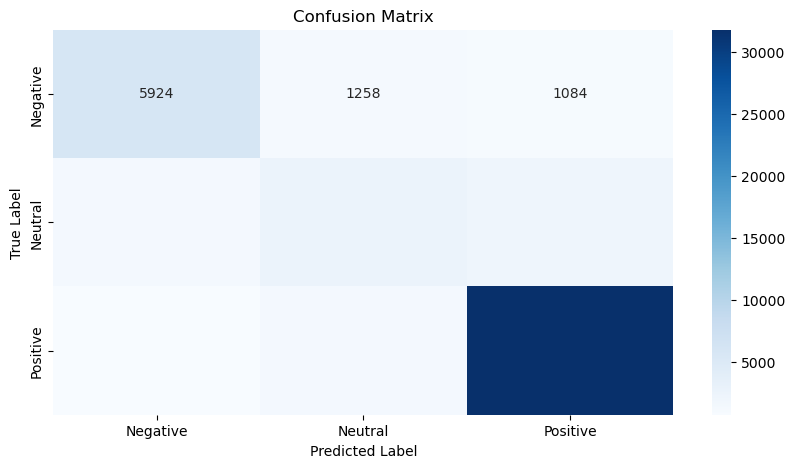

[[ 5924  1258  1084]
 [ 1391  2649  2132]
 [  733  1368 31771]]
              precision    recall  f1-score   support

    Negative       0.74      0.72      0.73      8266
     Neutral       0.50      0.43      0.46      6172
    Positive       0.91      0.94      0.92     33872

    accuracy                           0.84     48310
   macro avg       0.72      0.69      0.70     48310
weighted avg       0.83      0.84      0.83     48310



In [165]:
# 顯示 Confusion Matrix
y_pred_prob = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(cm)
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

## Random Forest Supervised Learning 2

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(max_features=5000)  
X_tfidf = tfidf.fit_transform(df['Review'])  # 利用 Tfidf 提取文本 Feature
y = df['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [190]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import StratifiedKFold, cross_val_predict  


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

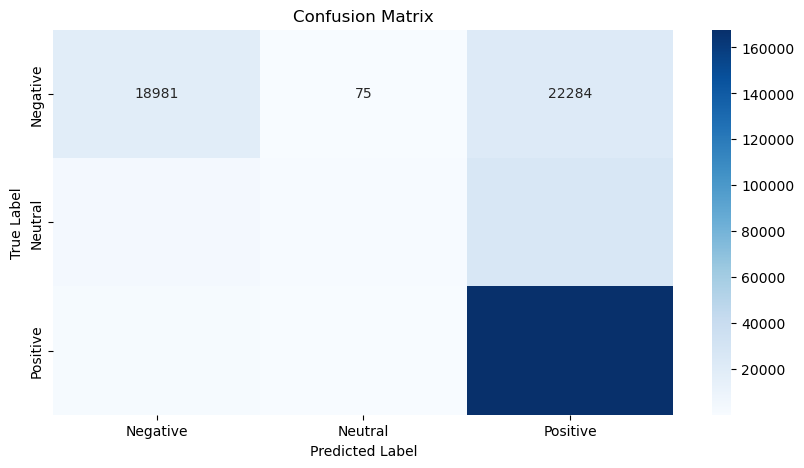

c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Confusion Matrix:
[[ 18981     75  22284]
 [  3359   1130  26391]
 [  1545     53 167730]]
              precision    recall  f1-score   support

    Negative       0.79      0.46      0.58     41340
     Neutral       0.90      0.04      0.07     30880
    Positive       0.78      0.99      0.87    169328

    accuracy                           0.78    241548
   macro avg       0.82      0.50      0.51    241548
weighted avg       0.79      0.78      0.72    241548



In [169]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 考慮平均分割各種 Label 的評論

# 從 cross_validation 中得到預測值，接著進行 confusion matrix 的計算
y_pred = cross_val_predict(rf, X_tfidf, y, cv=skf)

conf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 10})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:")
print(conf_matrix)

print(classification_report(y, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

## LDA Unsupervised Learning

In [ ]:
%pip install pyLDAvis

In [88]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis # 互動式LDA分析圖
import pyLDAvis
import re

LDA_df = df[['Review', 'Sentiment']]  
LDA_df.dropna(inplace=True)  

# 文本預處理，刪除標點符號、stopwords、轉小寫
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  
    text = text.lower()  
    tokens = word_tokenize(text)  
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  
    return tokens

LDA_df["Tokens"] = LDA_df["Review"].apply(preprocess_text)

In [ ]:
# 將處理過後的文本轉換為 Bag-of-Words 的 Feature
dictionary = corpora.Dictionary(LDA_df["Tokens"])
corpus = [dictionary.doc2bow(text) for text in LDA_df["Tokens"]]

num_topics = 3  
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

In [91]:
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.005*"one" + 0.004*"doctor" + 0.004*"series" + 0.004*"like" + 0.003*"also" + 0.003*"people" + 0.003*"character" + 0.003*"would" + 0.003*"even" + 0.003*"two"
Topic 2: 0.023*"show" + 0.016*"like" + 0.012*"good" + 0.011*"really" + 0.010*"one" + 0.010*"watch" + 0.009*"season" + 0.008*"series" + 0.008*"first" + 0.007*"time"
Topic 3: 0.027*"show" + 0.026*"series" + 0.017*"characters" + 0.017*"season" + 0.013*"story" + 0.009*"character" + 0.009*"one" + 0.008*"great" + 0.008*"best" + 0.008*"well"


In [92]:
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


In [93]:
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

Perplexity: -8.479733260962544


In [94]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=LDA_df["Tokens"], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")


Coherence Score: 0.3556294477911009


In [108]:
# 將評論歸類為機率最大的 Topic
def get_topic(text):
    bow_vector = dictionary.doc2bow(text)
    topic_probs = lda_model.get_document_topics(bow_vector)
    return max(topic_probs, key=lambda x: x[1])[0]  

LDA_df["LDA_Topic"] = LDA_df["Tokens"].apply(get_topic)

# 將 Topic 視為當中情緒標籤相同種類較多的情緒標籤
sentiment_mapping = LDA_df.groupby("LDA_Topic")["Sentiment"].agg(lambda x: x.value_counts().idxmax()) 
# 取得各個 Topic 當中情緒標籤的占比
sentiment_distribution = LDA_df.groupby("LDA_Topic")["Sentiment"].value_counts(normalize=True).unstack()

LDA_df["LDA_Predicted_Sentiment"] = LDA_df["LDA_Topic"].map(sentiment_mapping)

accuracy = accuracy_score(LDA_df["Sentiment"], LDA_df["LDA_Predicted_Sentiment"])
print(f"LDA Topic-Sentiment Accuracy: {accuracy:.4f}")
print(sentiment_distribution)


C:\Users\hp\AppData\Local\Temp\ipykernel_20472\645568299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LDA_df["LDA_Topic"] = LDA_df["Tokens"].apply(get_topic)
C:\Users\hp\AppData\Local\Temp\ipykernel_20472\645568299.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LDA_df["LDA_Predicted_Sentiment"] = LDA_df["LDA_Topic"].map(sentiment_mapping)
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. 

LDA Topic-Sentiment Accuracy: 0.7010
Sentiment  negative   neutral  positive
LDA_Topic                              
0          0.099751  0.110409  0.789839
1          0.251860  0.163464  0.584676
2          0.018743  0.035896  0.945362


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

## Data Augmentation

In [117]:
%pip install deep_translator

   ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
   --------- ------------------------------ 10.2/42.3 kB ? eta -:--:--
   ---------------------------------------- 42.3/42.3 kB 508.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [109]:
from sklearn.utils import resample
from deep_translator import GoogleTranslator

In [138]:
# Undersampling
df_majority = df[df["Sentiment"] == "positive"]
df_downsampled = resample(df_majority, replace=False, n_samples=52000, random_state=42)

aug_df = pd.concat([df[df["Sentiment"] != "positive"], df_downsampled])
aug_df[aug_df['Sentiment'] == "positive"].head()

# Oversampling
df_target = df[df["Rating"].between(2, 9)].copy()

aug_factor = 1.5
df_aug_list = []

# 先將評論翻譯為法文，再翻譯回英文
def back_translate(text, lang='fr'):
    try:
        translated = GoogleTranslator(source="auto", target=lang).translate(text)
        back_translated = GoogleTranslator(source=lang, target="en").translate(translated)
        return back_translated
    except:
        return text

# 擴增星等2~9的評論數
for rating in range(2, 10):
    df_subset = df_target[(df_target["Rating"]) == rating]
    num_samples = len(df_subset)
    num_augmented = int(num_samples * aug_factor / (num_samples / 8000)) # 增加資料數少的評論的擴增資料數，評論數原本就多者則減少增加量

    sampled_texts = df_subset.sample(n=num_augmented, replace=True, random_state=42)["Review"].to_list()

    augmented_texts = [back_translate(text) for text in sampled_texts]

    df_translated = df_subset.sample(n=num_augmented, replace=True, random_state=42).copy()
    df_translated["Review"] = augmented_texts

    df_aug_list.append(df_translated)

df_translated = pd.concat(df_aug_list, ignore_index=True)
aug_df = pd.concat([aug_df, df_translated], ignore_index=True)


c:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


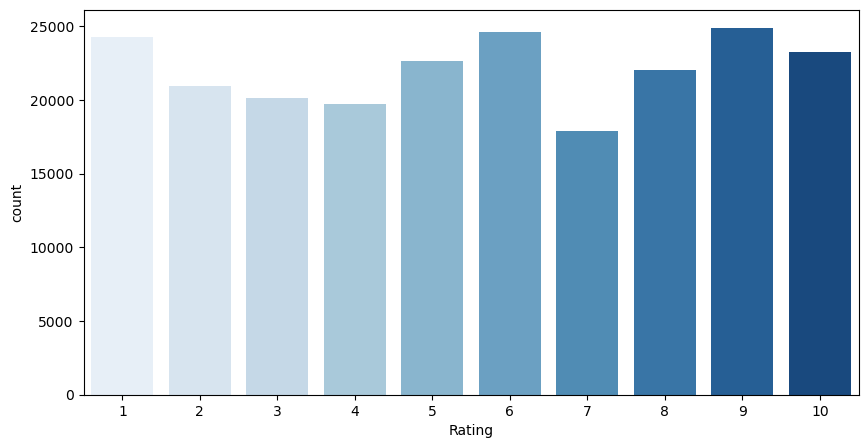

   Rating  count
0       9  24871
1       6  24581
2       1  24281
3      10  23271
4       5  22603
5       8  21993
6       2  20937
7       3  20122
8       4  19696
9       7  17865
           count
Sentiment       
neutral    84745
positive   70135
negative   65340


In [ ]:
# 重新定義情緒標籤的星等範圍
def map_sentiment(rating):
    if rating >= 8:
        return "positive"
    elif rating >= 4:
        return "neutral"
    else:
        return "negative"

aug_df["Sentiment"] = aug_df["Rating"].apply(map_sentiment)

# 列印 Data Augmentation 後的星等評論直方圖
aug_df['Rating'].value_counts()
tmp = pd.DataFrame(aug_df['Rating'].value_counts())
tmp = tmp.reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Rating', y='count', data=tmp, palette='Blues')
plt.show()

print(tmp)
print(pd.DataFrame(aug_df["Sentiment"].value_counts()))

## AUG LSTM

In [ ]:
# 接著演算法不變，僅輸出輸入資料改為擴增後的資料集 (aug_X, aug_y)
tokenizer = Tokenizer(num_words=5000, oov_token='{OOV}')
tokenizer.fit_on_texts(aug_df['Review'])
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
aug_df['Sentiment_label'] = aug_df['Sentiment'].map(label_mapping)
sequences = tokenizer.texts_to_sequences(aug_df['Review'])

aug_X = pad_sequences(sequences, maxlen=360)
aug_y = tf.keras.utils.to_categorical([l for l in aug_df['Sentiment_label']], num_classes=3)

aug_X_train, aug_X_test, aug_y_train, aug_y_test = train_test_split(aug_X, aug_y, test_size=0.2, random_state=42)

In [144]:
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(3, activation="softmax")  
])

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.fit(aug_X_train, aug_y_train, epochs=10, batch_size=32)

lstm_model.save("aug_sentiment_lstm_model.h5")

Epoch 1/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 761s 137ms/step - accuracy: 0.6226 - loss: 0.8171
Epoch 2/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 742s 135ms/step - accuracy: 0.7298 - loss: 0.6405
Epoch 3/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 645s 117ms/step - accuracy: 0.7722 - loss: 0.5614
Epoch 4/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 634s 115ms/step - accuracy: 0.8094 - loss: 0.4916
Epoch 5/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 633s 115ms/step - accuracy: 0.8387 - loss: 0.4346
Epoch 6/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 633s 115ms/step - accuracy: 0.8674 - loss: 0.3728
Epoch 7/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 633s 115ms/step - accuracy: 0.8899 - loss: 0.3215
Epoch 8/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 635s 115ms/step - accuracy: 0.9079 - loss: 0.2740
Epoch 9/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 633s 115ms/step - accuracy: 0.9226 - loss: 0.2384
Epoch 10/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 634s 115ms/step - accuracy: 0.9337 - loss: 0.2091


In [177]:
lstm_model = load_model("aug_sentiment_lstm_model.h5")

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step


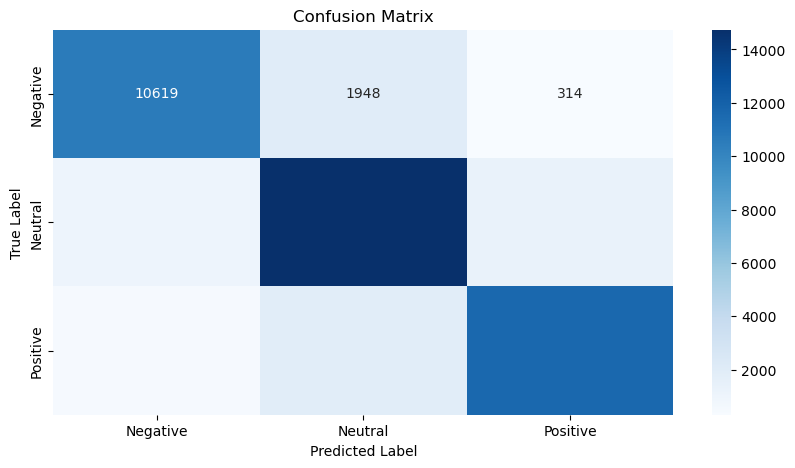

[[10619  1948   314]
 [ 1055 14737  1380]
 [  486  1922 11583]]
              precision    recall  f1-score   support

    Negative       0.87      0.82      0.85     12881
     Neutral       0.79      0.86      0.82     17172
    Positive       0.87      0.83      0.85     13991

    accuracy                           0.84     44044
   macro avg       0.85      0.84      0.84     44044
weighted avg       0.84      0.84      0.84     44044



In [178]:
loss, accuracy = lstm_model.evaluate(aug_X_test, aug_y_test)
print(f"Test Accuracy: {accuracy:.4f}")

aug_y_pred_prob = lstm_model.predict(aug_X_test)
aug_y_pred = np.argmax(aug_y_pred_prob, axis=1)
aug_y_true = np.argmax(aug_y_test, axis=1)

cm = confusion_matrix(aug_y_true, aug_y_pred)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(cm)

print(classification_report(aug_y_true, aug_y_pred, target_names=['Negative', 'Neutral', 'Positive']))

## AUG Random Forest

In [148]:
# 接著演算法不變，僅輸出輸入資料改為擴增後的資料集 (aug_X_tfidf, aug_y)
tfidf = TfidfVectorizer(max_features=5000)  
aug_X_tfidf = tfidf.fit_transform(aug_df['Review'])  
aug_y = aug_df['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})  

c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

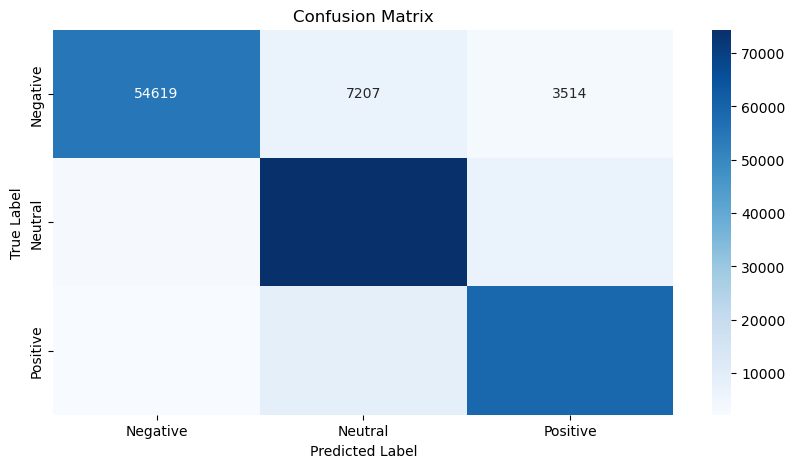

c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Confusion Matrix:
[[54619  7207  3514]
 [ 3250 74385  7110]
 [ 2211  8884 59040]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     65340
           1       0.82      0.88      0.85     84745
           2       0.85      0.84      0.84     70135

    accuracy                           0.85    220220
   macro avg       0.86      0.85      0.85    220220
weighted avg       0.86      0.85      0.85    220220



In [158]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aug_y_pred = cross_val_predict(rf, aug_X_tfidf, aug_y, cv=skf)

conf_matrix = confusion_matrix(aug_y, aug_y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 10})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(aug_y, aug_y_pred))

## AUG LDA

In [170]:
# 接著演算法不變，僅輸出輸入資料改為擴增後的資料集 (aug_LDA_df)
aug_LDA_df = aug_df[['Review', 'Sentiment']]  
aug_LDA_df.dropna(inplace=True)  

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  
    text = text.lower()  
    tokens = word_tokenize(text)  
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  
    return tokens

aug_LDA_df["Tokens"] = aug_LDA_df["Review"].apply(preprocess_text)

C:\Users\hp\AppData\Local\Temp\ipykernel_20472\2778929491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_LDA_df.dropna(inplace=True)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\hp\AppData\Local\Temp\ipykernel_20472\2778929491.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_LDA_df

In [171]:
dictionary = corpora.Dictionary(aug_LDA_df["Tokens"])
corpus = [dictionary.doc2bow(text) for text in aug_LDA_df["Tokens"]]

num_topics = 3  
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

In [172]:
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

In [173]:
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

coherence_model_lda = CoherenceModel(model=lda_model, texts=aug_LDA_df["Tokens"], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")


Perplexity: -8.267677230089012
Coherence Score: 0.2922738370022837


In [174]:
def get_topic(text):
    bow_vector = dictionary.doc2bow(text)
    topic_probs = lda_model.get_document_topics(bow_vector)
    return max(topic_probs, key=lambda x: x[1])[0]  

aug_LDA_df["LDA_Topic"] = aug_LDA_df["Tokens"].apply(get_topic)

sentiment_mapping = LDA_df.groupby("LDA_Topic")["Sentiment"].agg(lambda x: x.value_counts().idxmax())
sentiment_distribution = LDA_df.groupby("LDA_Topic")["Sentiment"].value_counts(normalize=True).unstack()

aug_LDA_df["LDA_Predicted_Sentiment"] = aug_LDA_df["LDA_Topic"].map(sentiment_mapping)

accuracy = accuracy_score(aug_LDA_df["Sentiment"], aug_LDA_df["LDA_Predicted_Sentiment"])
print(f"LDA Topic-Sentiment Accuracy: {accuracy:.4f}")
print(sentiment_distribution)

C:\Users\hp\AppData\Local\Temp\ipykernel_20472\3951279454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_LDA_df["LDA_Topic"] = aug_LDA_df["Tokens"].apply(get_topic)
C:\Users\hp\AppData\Local\Temp\ipykernel_20472\3951279454.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_LDA_df["LDA_Predicted_Sentiment"] = aug_LDA_df["LDA_Topic"].map(sentiment_mapping)
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in 

LDA Topic-Sentiment Accuracy: 0.3185
Sentiment  negative   neutral  positive
LDA_Topic                              
0          0.099751  0.110409  0.789839
1          0.251860  0.163464  0.584676
2          0.018743  0.035896  0.945362


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

## LSTM Star

In [188]:
# 腹死胎中的第二個實驗
tokenizer = Tokenizer(num_words=5000, oov_token='{OOV}')
tokenizer.fit_on_texts(aug_df['Review'])

sequences = tokenizer.texts_to_sequences(aug_df['Review'])

aug_X_star = pad_sequences(sequences, maxlen=360)
aug_y_star = np.array(aug_df['Rating'])

aug_X_train_star, aug_X_test_star, aug_y_train_star, aug_y_test_star = train_test_split(aug_X_star, aug_y_star, test_size=0.2, random_state=42)

In [185]:
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation="linear")  
])

lstm_model.compile(loss="mse", optimizer="adam", metrics=["mae"])
lstm_model.fit(aug_X_train_star, aug_y_train_star, epochs=10, batch_size=32, validation_data=(aug_X_test_star, aug_y_test_star))

lstm_model.save("aug_star_sentiment_lstm_model.h5")

Epoch 1/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 832s 150ms/step - loss: 6.9129 - mae: 2.1016 - val_loss: 3.0109 - val_mae: 1.3293
Epoch 2/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 825s 150ms/step - loss: 3.4009 - mae: 1.4247 - val_loss: 3.0171 - val_mae: 1.3262
Epoch 3/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 804s 146ms/step - loss: 2.8119 - mae: 1.2828 - val_loss: 2.6684 - val_mae: 1.1981
Epoch 4/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 873s 158ms/step - loss: 2.4296 - mae: 1.1830 - val_loss: 2.6171 - val_mae: 1.1798
Epoch 5/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 1006s 183ms/step - loss: 2.1708 - mae: 1.1083 - val_loss: 2.5590 - val_mae: 1.1502
Epoch 6/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 954s 173ms/step - loss: 1.9341 - mae: 1.0434 - val_loss: 2.5433 - val_mae: 1.1175
Epoch 7/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 965s 175ms/step - loss: 1.7225 - mae: 0.9811 - val_loss: 2.5165 - val_mae: 1.1058
Epoch 8/10
5506/5506 ━━━━━━━━━━━━━━━━━━━━ 1003s 182ms/step - loss: 1.5935 - mae: 0.9438 - val_loss: 2.5163 - val_mae: 1.0840
Epoch 

In [186]:
mse, mae = lstm_model.evaluate(aug_X_test_star, aug_y_test_star)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 62s 45ms/step - loss: 2.4796 - mae: 1.0526
MSE: 2.4471, MAE: 1.0523


In [ ]:
lstm_model = load_model("aug_sentiment_lstm_model.h5")

In [ ]:
print(len())

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step


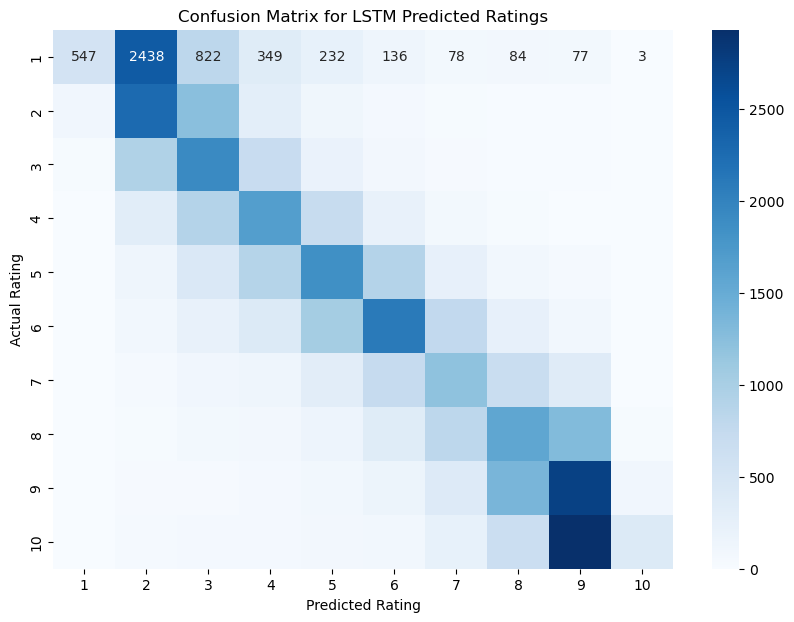

In [189]:
aug_y_pred_star = lstm_model.predict(aug_X_test_star)

aug_y_pred_rounded_star = np.round(aug_y_pred_star).astype(int)
aug_y_test_rounded_star = aug_y_test_star.astype(int)  

cm = confusion_matrix(aug_y_test_rounded_star, aug_y_pred_rounded_star, labels=np.arange(1, 11))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 11))
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix for LSTM Predicted Ratings")
plt.show()